In [3]:
#| output: true
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

#Hyperparameters
batch_size = 64 #Number of token chunks per batch #UPDATED
context_length = 256 #Length of the token chunks. Andrej called this block size #UPDATED
embedding_dim = 384 #The vector size of the token embeddings. Andrej used n_embed as the variable name. #UPDATED
head_size1 = 16 #Self attention head size
num_layers = 6 #Number of transformer block layers # NEW
num_heads = 6  # NEW
learning_rate = 3e-4 #UPDATED
dropout = 0.2 #NEW
max_iters = 5000 #Number of training iterations or steps.
eval_interval = 500 #Number of steps between evaluating the validation set to see how our validation loss is doing. #UPDATED
eval_iters = 200 #Number of steps to do on the validation set per each interval. We do more than 1 to get a more accurate overall valid loss
device = 'cuda' if torch.cuda.is_available() else 'cpu' #Instead of using the cpu, we'll use the GPU if it's availble.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

#Dataset
with open('vefxistyaosani.txt','r',encoding='utf-8') as f:
    text = f.read()
vocab = sorted(list(set(text))) #Called chars in the video, but vocab is a more generic term. Both are correct.
vocab_size = len(vocab)

char2idx = {char:idx for idx,char in enumerate(vocab)}
idx2char = {idx:char for char,idx in char2idx.items()}
encode = lambda x: [char2idx[char] for char in x]
decode = lambda idxs: ''.join([idx2char[idx] for idx in idxs])

tokenized_text = torch.tensor(encode(text),dtype=torch.long)

#Train / Valid split.
train_test_split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:train_test_split_idx]
valid_data = tokenized_text[train_test_split_idx:]

In [4]:
#| output: true
def plot_losses(losses):
    train_losses = [o['train'] for o in losses if o.get('train') is not None]
    valid_losses = [o['valid'] for o in losses if o.get('valid') is not None]
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.show()

In [5]:
#| output: true
def get_batch(split:str, batch_size:int=batch_size, context_length:int=context_length):
    #Function to get a batch of data from the train or valid dataset
    data = train_data if split == 'train' else valid_data
    idxs = torch.randint(low=0, high=len(data)-context_length, size=(batch_size,))
    x = torch.stack([data[idx:idx+context_length] for idx in idxs])
    y = torch.stack([data[idx+1:idx+context_length+1] for idx in idxs])
    x,y = x.to(device), y.to(device) #Send data to the GPU if available
    return x,y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train','valid']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x_batch, y_batch = get_batch(split)
            logits, loss = model(x_batch, y_batch)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [6]:
#| output: true
class FeedForwardNetwork(nn.Module):
    """A simple linear network followed by a non-linearity"""
    def __init__(self, embedding_dim:int=embedding_dim, dropout:float=dropout):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.ffn = nn.Sequential(
            nn.Linear(in_features=self.embedding_dim, out_features=self.embedding_dim*4),
            nn.ReLU(),
            nn.Linear(in_features=self.embedding_dim*4, out_features=self.embedding_dim),
            nn.Dropout(dropout), #NEW
        )
    def forward(self, x):
        return self.ffn(x)

In [7]:
#| output: true
class Head(nn.Module):
    """ one head of self attention """
    def __init__(self, head_size:int, embedding_dim:int=embedding_dim,
                 context_length:int=context_length, dropout:float=dropout):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.head_size = head_size
        self.context_length = context_length
        self.dropout = dropout

        self.key_layer   = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.query_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.value_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones((self.context_length, self.context_length))))
        self.dropout_layer = nn.Dropout(dropout) # NEW

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        assert T <= self.context_length
        assert C == self.embedding_dim
        q = self.query_layer(x) #(B,T,C) (batch size, context length, head_size)
        k = self.key_layer(x) #(B,T,C) (batch size, context length, head_size)
        v = self.value_layer(x) #(B,T,C) (batch size, context length, head_size)

        #compute scores based on affinities
        weights = (q @ k.transpose(-2,-1)) * self.head_size**-0.5 # (B,T,C) @ (B,C,T) -> (B,T,T) #FIXED ^-.5 is 1/sqrt() so need to mult, not div
        weights = weights.masked_fill(self.tril[:T,:T] == 0, float('-inf')) #(B,T,T)
        weights = F.softmax(input=weights, dim=-1) #(B,T,T)
        weights = self.dropout_layer(weights) # NEW

        #perform weighted aggragation of the values
        out = weights @ v # (B,T,T) @ (B,T,C) -> (B,T,C)
        return out

# Head()(x)

In [8]:
#| output: true
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads:int, head_size:int, embedding_dim:int=embedding_dim,
                 context_length:int=context_length, dropout:float=dropout):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.dropout = dropout

        self.heads = nn.ModuleList([
            Head(head_size=self.head_size, embedding_dim=self.embedding_dim,
                 context_length=self.context_length)
            for _ in range(self.num_heads)])

        self.projection_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.embedding_dim, bias=True)
        self.dropout_layer = nn.Dropout(dropout) # NEW

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection_layer(out)
        out = self.dropout_layer(out) # NEW
        return out

In [9]:
#| output: true
class TransformerBlock(nn.Module):
    """Transformer Block: Communication folled by computation."""
    def __init__(self, num_heads:int, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 dropout:float=dropout): #UPDATED
        #embedding_dim: embedding dimension, num_heads: the number of heads that we want
        super().__init__()
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = embedding_dim // num_heads
        self.num_heads = num_heads
        self.dropout = dropout # NEW

        self.multi_self_attention_heads_layer = MultiHeadAttention(num_heads=num_heads, head_size=self.head_size,
                                                                   embedding_dim=embedding_dim, context_length=context_length,
                                                                   dropout=dropout) #UPDATED
        self.feed_forward_network = FeedForwardNetwork(embedding_dim=self.embedding_dim, dropout=dropout)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=self.embedding_dim)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=self.embedding_dim)

    def forward(self, x):
        x = x + self.multi_self_attention_heads_layer(self.layer_norm_1(x))
        x = x + self.feed_forward_network(self.layer_norm_2(x))
        return x


In [10]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


Step: 0 Training Loss: 4.003 Validation Loss: 4.003
Step: 200 Training Loss: 2.469 Validation Loss: 2.469
Step: 400 Training Loss: 2.186 Validation Loss: 2.204
Step: 600 Training Loss: 1.898 Validation Loss: 1.915
Step: 800 Training Loss: 1.702 Validation Loss: 1.745
Step: 1000 Training Loss: 1.561 Validation Loss: 1.643
Step: 1200 Training Loss: 1.46 Validation Loss: 1.583
Step: 1400 Training Loss: 1.368 Validation Loss: 1.544
Step: 1600 Training Loss: 1.281 Validation Loss: 1.527
Step: 1800 Training Loss: 1.205 Validation Loss: 1.523
Step: 2000 Training Loss: 1.123 Validation Loss: 1.522
Step: 2200 Training Loss: 1.043 Validation Loss: 1.549


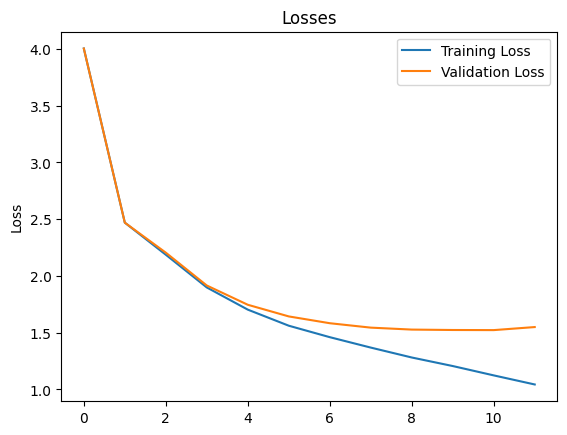


მისსა გარებდა, გითხრობ შენა ჩენკენალსა.
კვლა ატირდეს მიენდორს ღაწვთა, დღეცა ბადნი მკლევიან,
მეფე დიდებულთა, მისთა კბილმან, ვითა მეტად ვიან;
მისგან ნაცვლად ყოვლისა ამოს, რომ ცუდად ივარე,
რაცა ვნახავს სტირ, მსგავსი სიკვდილი ჩემზეებრ მემცა შენით".

მღმერთო, გკადრებ, გიბი უშმაგო დავასწევ, გულისა დამემინები;
ეგრეცა გვეუშვარ მაგრა დაგზავნი, აქა გამსახურები,
გავუღარი, არას მომადგებმა დაველი, არა დამექონები;
გულსა გამეშველა მისწრა, არცა მომივალე, ნაქმე კარები:
შენთა, შეცვლად შემოგებე, სჯერდი რომე გული წ
CPU times: user 9min, sys: 4.9 s, total: 9min 5s
Wall time: 9min 3s


In [11]:
%%time
#| output: true
torch.manual_seed(TORCH_SEED)
class TransformerLanguageModel(nn.Module):
    def __init__(self, head_size:int, vocab_size:int=vocab_size, embedding_dim:int=embedding_dim, context_length:int=context_length,
                 num_layers:int=num_layers, dropout:float=dropout, num_heads:int=num_heads): #UPDATED
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_length = context_length
        self.head_size = head_size
        self.num_layers = num_layers #NEW
        self.dropout = dropout

        self.token_embedding_table = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.token_position_embedding_table = nn.Embedding(num_embeddings=self.context_length, embedding_dim=self.embedding_dim)

        self.transformer_blocks = nn.Sequential(*([
            TransformerBlock(embedding_dim=embedding_dim, num_heads=num_heads, context_length=context_length,
                             dropout=self.dropout) for _ in range(self.num_layers)]+[
            nn.LayerNorm(embedding_dim)
        ])) #UPDATED
        self.language_model_head_linear_layer = nn.Linear(in_features=self.embedding_dim, out_features=self.vocab_size)

    def forward(self, idx, targets=None):
        #Both idx and targets are (B,T) Batch x Time array of integers
        B,T = idx.shape
        token_embeddings = self.token_embedding_table(idx) #(B,T,C) Batch, Time, Channel
        token_position_embeddings = self.token_position_embedding_table(torch.arange(T, device=device)) #(T,C)
        x = token_embeddings + token_position_embeddings
        x = self.transformer_blocks(x)
        logits = self.language_model_head_linear_layer(x) #(B,T,C) Where C is now token logits of size vocab_size

        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array of indicies in the current context
        for _ in range(max_new_tokens):
            #Crop idx to the max size of our positional embeddings table
            idx_crop = idx[:,-self.context_length:]
            #Get predictions
            logits, loss = self(idx_crop)
            #Get the last time step from logits where the dimensions of the logits are (B,T,C)
            logits_last_timestep = logits[:,-1,:] #Becomes (B,C)
            #Apply softmax to get probabilities
            probs = F.softmax(input=logits_last_timestep, dim=-1) #(B,C)
            #Sample from the probs distribution.
            idx_next = torch.multinomial(input=probs, num_samples=1) #(B,1) Returns (B,idxs) where idxs are random integer indicies.
            #Append the sampled indexes idx_next to idx
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx

model = TransformerLanguageModel(head_size=head_size1, vocab_size=vocab_size, embedding_dim=embedding_dim, context_length=context_length)
model = model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
early_stopper = EarlyStopper(patience=3, min_delta=0)
for step in range(max_iters):
    if step % eval_iters == 0 or step == max_iters-1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:',step,'Training Loss:',round(losses['train'].item(),3),'Validation Loss:',round(losses['valid'].item(),3))

    xb,yb = get_batch('train')
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if early_stopper.early_stop(losses['valid'].item()):
        break

plot_losses(tracked_losses)
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context,max_new_tokens=500)[0].tolist()))

In [13]:
encode('იყო არაბეთს როსტევან')

[22, 37, 27, 1, 14, 30, 14, 15, 18, 21, 31, 1, 30, 27, 31, 32, 18, 19, 14, 26]

In [22]:
context.shape

torch.Size([1, 1])

In [32]:
c2 = torch.tensor(encode('იყო არაბეთს როსტე'), dtype=torch.long, device=device)

In [67]:
c2.unsqueeze(1).unsqueeze(0)[:,-4:,:]#.shape

tensor([[[27],
         [31],
         [32],
         [18]]], device='cuda:0')

In [35]:
print(decode(model.generate(c2.unsqueeze(1),max_new_tokens=500)[0].tolist()))

იარდე, ვინცა ვხედნა,
ვინ აჭრებდეს, გარდუმდის ყოვლგნი, ასრევდეს,
დაჰყოს ლომი მიეფისათვის, დალეწეს მკვდარი.

ავთანდილ ყმა, თუ: ნაწყრობად დასაგდებოდა;
რა მაშინ, დაიგდეს, ჰკადრნეს უჩუო განანადირობდა;
ზდაჯე უჭვრეტს ყელსა ყოვლგან ვერცა საჭვრეტლად ირებოდა:
მგითხრობდით, ჩემგვარ რა კვლაცა ჩემიცა დააგდებოდა;
არ ით ნახა წავიმაჭვ, არ მისი მეამებოდან.

გამირბეთ საუბარად უთვარა, კვლა სულთქნა სიტკბდიროდა.
ქედს გააგეკივიფარდა, გააპარა მჯობს რიდე!
ქონაიმე ქალინი, რკინა, საჭვრეტელი ჩემი თანა ბარი;
ოდიოდ გაუმუზრავი
